# Exercise: Cache Bandwidths

In this exercise you will benchmark a **Schoenauer triad** kernel (i.e. `a[i] = b[i] + c[i] * d[i]`) and see how the observed performance is effected by the memory hierarchy, i.e. different cache levels.

**Hint:** On most systems, you can programmatically query the cache sizes via

```julia
using CpuId
cachesize()
```

(It doesn't work on Apple silicon.)

## Tasks

1) Inspect the code below and implement the missing piece (look for the TODO annotation).

In [7]:
using Plots
using BenchmarkTools
using CpuId
using Statistics

"""
SDAXPY: `y[i] = a[i] * x[i] + y[i]` (Schoenauer triad without write-allocate.)

The arguments `y, a, x` are vectors of length `n`.
"""
function sdaxpy!(y, a, x, n)
    #
    # TODO: Implement the SDAXPY kernel. Use `@inbounds` to turn-off bound checks.
    #
    for i in 1:n
        @inbounds y[i] = a[i] * x[i] + y[i] # 8 bytes x 4 = 32 bytes data transfer
    end
end

"""
    vector_lengths(lo::Integer, hi::Integer, ni::Integer; factor::Integer=32)

Given some lower (`lo`) and upper (`hi`) bound in bytes, returns ≤ ni distinct integers
that are
- more or less evenly separated between lo and hi
- multiples of `factor`

These integers are to be used as vector lengths for the inputs to `sdaxpy!` and determine
the number of loop iterations therein.
"""
function vector_lengths(lo::Integer, hi::Integer, ni::Integer; factor::Integer=32)
    r_log = range(log10(lo / 32), log10(hi / 32), ni)
    r = round.(Integer, exp10.(r_log))
    r_factor = r .& (~(factor-1)) # biggest multiple of factor <= number
    return unique(r_factor)
end

"""
Perform a benchmark of the SDAXPY kernel (Schoenauer triad without write-allocate).
See `vector_lengths` for explanations of the input arguments.
"""
function bench(lo, hi, n; nbench, kwargs...)
    ts = Float64[]
    Ns = vector_lengths(lo, hi, n; kwargs...)
    for n in Ns
        y = fill(1.2, n)
        a = fill(0.8, n)
        x = fill(3.14, n)
        t = @belapsed for i in 1:$nbench
            sdaxpy!($y, $a, $x, $n)
        end samples = 30
        push!(ts, t / nbench)
        println("finished n = $n, time: ", ts[end], " sec bandwidth: ", 32.0e-9 * n / ts[end], " GB/s")
        flush(stdout)
    end
    return Ns, ts
end

function plot_results(Ns, ts)
    p = plot(Ns, Ns ./ ts .* 32.0e-9, marker=:circle, label="sdaxpy!", frame=:box, ms=2, xscale=:log10)
    ylabel!(p, "bandwidth [GB/s]")
    xlabel!(p, "vector size n")
    L1, L2, L3 = cachesize()
    mem = 4 * sizeof(Float64) # four arrays a, b, c, and d in `sdaxpy!`
    nL1 = L1 / mem
    nL2 = L2 / mem
    nL3 = L3 / mem
    vline!(p, [nL1], color=:orange, lw=2, label="L1 = $(floor(Int, nL1)) ($(L1/1024) KiB)")
    vline!(p, [nL2], color=:red, lw=2, label="L2 = $(floor(Int, nL2)) ($(L2/1024) KiB)")
    vline!(p, [nL3], color=:purple, lw=2, label="L3 = $(floor(Int, nL3)) ($(L3/1024) KiB)")
    return p
end

"""
Will perform the benchmark and save a plot of the results as png/svg files.
"""
function main()
    L1, L2, L3 = cachesize()
    Ns1, ts1 = bench(1024, L1, 12; nbench=2^24, factor=32)
    Ns2, ts2 = bench(round(Integer, L1 * 1.5), L2, 10; nbench=2^14, factor=64)
    Ns3, ts3 = bench(round(Integer, L2 * 1.5), L3, 10; nbench=2^10, factor=128)
    Ns4, ts4 = bench(round(Integer, L3 * 1.5), L3 * 32, 8; nbench=2^4, factor=64)
    p = plot_results(vcat(Ns1, Ns2, Ns3, Ns4), vcat(ts1, ts2, ts3, ts4))
    savefig(p, "sdaxpy_contiguous.svg")
    println("L1 bandwidth:\t", round(median(32.0e-9 .* Ns1 ./ ts1); digits=2), " GB/s")
    println("L2 bandwidth:\t", round(median(32.0e-9 .* Ns2 ./ ts2); digits=2), " GB/s")
    println("L3 bandwidth:\t", round(median(32.0e-9 .* Ns3 ./ ts3); digits=2), " GB/s")
    println("Memory bandwidth:\t", round(median(32.0e-9 .* Ns4 ./ ts4); digits=2), " GB/s")
    return p
end

main

2) Run the benchmark by calling the `main()` function. (Note that this can take up to ~7 minutes.)

finished n = 32, time: 5.4151559472084045e-9 sec bandwidth: 189.0988939160446 GB/s
finished n = 64, time: 7.848282277584076e-9 sec bandwidth: 260.9488200812309 GB/s
finished n = 96, time: 1.1638838469982147e-8 sec bandwidth: 263.9438641513093 GB/s
finished n = 128, time: 1.5426499128341673e-8 sec bandwidth: 265.51714461739414 GB/s
finished n = 192, time: 2.3013561606407165e-8 sec bandwidth: 266.97301813072954 GB/s
finished n = 288, time: 3.4386459350585936e-8 sec bandwidth: 268.012472759658 GB/s
finished n = 384, time: 4.5760050237178804e-8 sec bandwidth: 268.53117372708505 GB/s
finished n = 544, time: 6.472180384397507e-8 sec bandwidth: 268.96654552406306 GB/s
finished n = 736, time: 8.74673325419426e-8 sec bandwidth: 269.26624278505665 GB/s
finished n = 1024, time: 1.4024274015426636e-7 sec bandwidth: 233.652023370018 GB/s
finished n = 1536, time: 2.805280151367187e-7 sec bandwidth: 175.2124470564738 GB/s
finished n = 1984, time: 3.73152587890625e-7 sec bandwidth: 170.139514129831 GB

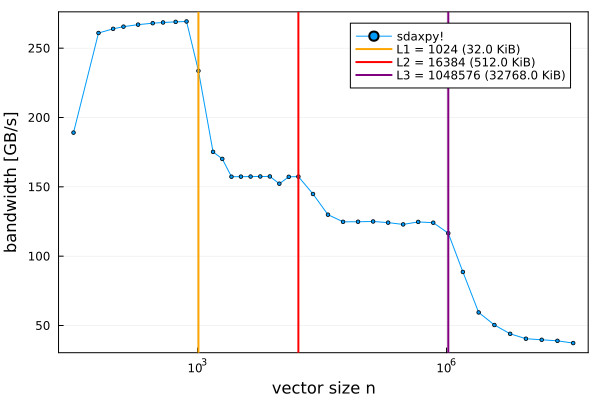

In [8]:
@time main()

* **Questions**
  * Do you understand the trend of the resulting plot?
  * Which bandwidth estimates (in GB/s) do you obtain for L1, L2, L3, and main memory? (Check the textual output of the benchmark.) Fill out the table below.
  
HPC cluster name: Noctua 2, CPU: AMD EPYC 7763:

|  measurements   |  bandwidth [GB/s] |
|:---------------:|:-----------------:|
|  L1D cache      |  266              |
|  L2  cache      |  157              |
|  L3  cache      |  124              |
|  main memory    |  42               |


Let's now investigate the performance impact of **strided data access** in comparison to the contiguous data access (as benchmarked above).

3) Copy the entire code from above in the cell below and modify the `sdaxpy!` function such that it only performs the SDAXPY computation to every other vector element (i.e. instead of `1:n` you iterate over `1:2:n`). This corresponds to a stride size of 2.

4) Since we now only perform half as many operations and thus only half of the data transfer, we need to account for this change in all bandwidth computations. Specifically, check all lines that contain `32.0e-09` and insert an extra factor of 0.5.

In [9]:
using Plots
using BenchmarkTools
using CpuId

"""
SDAXPY: `y[i] = a[i] * x[i] + y[i]` (Schoenauer triad without write-allocate.)

The arguments `y, a, x` are vectors of length `n`.
"""
function sdaxpy!(y, a, x, n)
    #
    # TODO: Implement the SDAXPY kernel. Use `@inbounds` to turn-off bound checks.
    #
    for i in 1:2:n
        @inbounds y[i] = a[i] * x[i] + y[i] # 8 bytes x 4 = 32 bytes data transfer
    end
end

"""
    vector_lengths(lo::Integer, hi::Integer, ni::Integer; factor::Integer=32)

Given some lower (`lo`) and upper (`hi`) bound in bytes, returns ≤ ni distinct integers
that are
- more or less evenly separated between lo and hi
- multiples of `factor`

These integers are to be used as vector lengths for the inputs to `sdaxpy!` and determine
the number of loop iterations therein.
"""
function vector_lengths(lo::Integer, hi::Integer, ni::Integer; factor::Integer=32)
    r_log = range(log10(lo / 32), log10(hi / 32), ni)
    r = round.(Integer, exp10.(r_log))
    r_factor = r .& (~(factor-1)) # biggest multiple of factor <= number
    return unique(r_factor)
end

"""
Perform a benchmark of the SDAXPY kernel (Schoenauer triad without write-allocate).
See `vector_lengths` for explanations of the input arguments.
"""
function bench(lo, hi, n; nbench, kwargs...)
    ts = Float64[]
    Ns = vector_lengths(lo, hi, n; kwargs...)
    for n in Ns
        y = fill(1.2, n)
        a = fill(0.8, n)
        x = fill(3.14, n)
        t = @belapsed for i in 1:$nbench
            sdaxpy!($y, $a, $x, $n)
        end samples = 30
        push!(ts, t / nbench)
        println("finished n = $n, time: ", ts[end], " sec bandwidth: ", 0.5 * 32.0e-9 * n / ts[end], " GB/s")
        flush(stdout)
    end
    return Ns, ts
end

function plot_results(Ns, ts)
    p = plot(Ns, Ns .* 0.5 ./ ts .* 32.0e-9, marker=:circle, label="sdaxpy!", frame=:box, ms=2, xscale=:log10)
    ylabel!(p, "bandwidth [GB/s]")
    xlabel!(p, "vector size n")
    L1, L2, L3 = cachesize()
    mem = 4 * sizeof(Float64) # four arrays a, b, c, and d in `sdaxpy!`
    nL1 = L1 / mem
    nL2 = L2 / mem
    nL3 = L3 / mem
    vline!(p, [nL1], color=:orange, lw=2, label="L1 = $(floor(Int, nL1)) ($(L1/1024) KiB)")
    vline!(p, [nL2], color=:red, lw=2, label="L2 = $(floor(Int, nL2)) ($(L2/1024) KiB)")
    vline!(p, [nL3], color=:purple, lw=2, label="L3 = $(floor(Int, nL3)) ($(L3/1024) KiB)")
    return p
end

"""
Will perform the benchmark and save a plot of the results as png/svg files.
"""
function main()
    L1, L2, L3 = cachesize()
    Ns1, ts1 = bench(1024, L1, 12; nbench=2^24, factor=32)
    Ns2, ts2 = bench(round(Integer, L1 * 1.5), L2, 10; nbench=2^14, factor=64)
    Ns3, ts3 = bench(round(Integer, L2 * 1.5), L3, 10; nbench=2^10, factor=128)
    Ns4, ts4 = bench(round(Integer, L3 * 1.5), L3 * 32, 8; nbench=2^4, factor=64)
    p = plot_results(vcat(Ns1, Ns2, Ns3, Ns4), vcat(ts1, ts2, ts3, ts4))
    savefig(p, "sdaxpy_strided.svg")
    println("L1 bandwidth:\t", round(median(32.0e-9 .* 0.5 .* Ns1 ./ ts1); digits=2), " GB/s")
    println("L2 bandwidth:\t", round(median(32.0e-9 .* 0.5 .* Ns2 ./ ts2); digits=2), " GB/s")
    println("L3 bandwidth:\t", round(median(32.0e-9 .* 0.5 .* Ns3 ./ ts3); digits=2), " GB/s")
    println("Memory bandwidth:\t", round(median(32.0e-9 .* 0.5 .* Ns4 ./ ts4); digits=2), " GB/s")
    return p
end

main

5) Run the benchmark for the strided SDAXPY. How do the results compare to the contiguous case? What's the reason?

finished n = 32, time: 1.0445815563201905e-8 sec bandwidth: 49.01484205825468 GB/s
finished n = 64, time: 2.1113772749900817e-8 sec bandwidth: 48.499148500346074 GB/s
finished n = 96, time: 2.3827497363090515e-8 sec bandwidth: 64.46333731965107 GB/s
finished n = 128, time: 3.844365453720093e-8 sec bandwidth: 53.27277088129599 GB/s
finished n = 192, time: 4.4196356475353244e-8 sec bandwidth: 69.50799217381521 GB/s
finished n = 288, time: 8.608805388212204e-8 sec bandwidth: 53.5265904176392 GB/s
finished n = 384, time: 8.816948491334915e-8 sec bandwidth: 69.68397293052325 GB/s
finished n = 544, time: 1.554297358393669e-7 sec bandwidth: 55.9995804727828 GB/s
finished n = 736, time: 1.6156063103675844e-7 sec bandwidth: 72.88904434472475 GB/s
finished n = 1024, time: 2.8534083700180053e-7 sec bandwidth: 57.419050747007574 GB/s
finished n = 1536, time: 3.6404522705078124e-7 sec bandwidth: 67.50809562618399 GB/s
finished n = 1984, time: 5.48859619140625e-7 sec bandwidth: 57.83628252649203 GB/

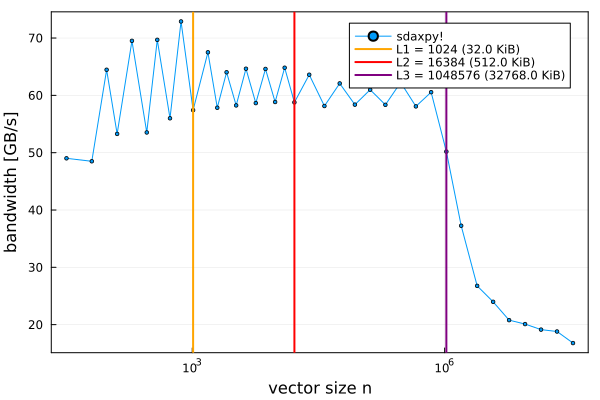

In [10]:
@time main()